# Boundary Value Problems

___

Firstly, I load necessary libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt

___

### Problem 1

#### Part a)
Implement the tridiagonal solver seen in class.

##### Solution

In [2]:
def TriDiagSolver(M, D):
    """
    M: The input tridiagonal matrix
    D: The equation solutions
    returns a vector of solutions to the equation Mx = D
    """
    b = np.diag(M, k = 1)
    a = np.diag(M, k = 0)
    c = np.diag(M, k = -1)
    
    N = len(a)
    m = np.zeros(N)
    l = np.zeros(N)
    y = np.zeros(N)
    x = np.zeros(N)
    
    m[0] = a[0]
    for j in range(N-1):
        l[j] = c[j]/m[j]
        m[j+1] = a[j+1]-(l[j]*b[j])
    
    y[0] = D[0]
    for i in range(1, N):
        y[i] = D[i]-(l[i-1]*y[i-1])
    
    x[-1] = y[-1]/m[-1]
    for k in reversed(range(N-1)):
        x[k] = (y[k]-(b[k]*x[k+1]))/m[k]
    return x

#### Part b)
Test your implementation.

##### Solution
I create an arbitrary tridiagonal matrix with random numbers on the diagonals and compare it to numpy's solver.

In [3]:
def createRandomTriDiagMatrix(N):
    A = np.zeros((N,N))
    np.fill_diagonal(A, np.random.normal(20, 100, N))
    np.fill_diagonal(A[1:], np.random.normal(20, 100, N-1))
    np.fill_diagonal(A[:,1:], np.random.normal(20, 100, N-1))
    return A

def testIsClose(A,b):
    my_sol = TriDiagSolver(A,b)
    np_sol = np.linalg.solve(A,b)
    return np.all(np.isclose(my_sol, np_sol))

Using the functions above, we now check to see if our random matrices are all solved correctly according to numpy's solution.

In [4]:
n_tests = 1000
tests = [testIsClose(createRandomTriDiagMatrix(10), np.random.normal(10, 5, 10)) for i in range(n_tests)]
print("Number of tests ran: {} Number of correct solutions: {}".format(n_tests, np.sum(tests)))

Number of tests ran: 1000 Number of correct solutions: 1000


As seen above, even with 1000 tests of random matrices, all of them are correctly solved.

____

### Problem 2
Consider the boundary value problem:

\begin{equation}
-u'' + \pi^{2}u = 2\pi^{2}\sin(\pi x) \quad 0 < x < 1\\
u(0) = u(1) = 0
\end{equation}

We can find a numerical approximation to the solution of this problem by employing the finite difference method. Use a uniform grid with $N-1$ interior nodes to obtain, by replacing the second derivative with a second order finite difference and neglecting the (truncation) error, the linear system

\begin{equation}
\frac{-v_{j-1}+2v_{j} - v_{j+1}}{h^{2}} + \pi^{2}v_{j} = 2\pi^{2}\sin(\pi x_{j}) \quad \textrm{ for } j = 1, 2, \dots, N-1
\end{equation}
where $h = \frac{1}{N}, v_{j}$ is the approximation in $u(x_{j})$ for $j = 1,2,\dots , N-1$, and $v_{0} = v_{n} = 0$. 

##### Part a)
Use your tridiagonal solver to solve $(2)$ for $N=50$ and plot your corresponding solution.

Firstly I define some helper functions to carry out the questions in this problem.

In [5]:
def L_p_Norm(X, Y, p):
    return np.sum(np.abs(X.flatten() - Y.flatten())**p)**(1/p)
    
def getNodes(N, start = 0):
    return [start + i/N for i in range(1,N)]

def createBDYTriDiagMatrix(N, diag_fill):
    A = np.zeros((N,N))
    np.fill_diagonal(A, diag_fill)
    np.fill_diagonal(A[1:], -1)
    np.fill_diagonal(A[:,1:], -1)
    return A

def boundaryProblem(N, f, c):
    h = 1/N
    X = getNodes(N)
    F = np.vectorize(f)(X).reshape((N-1,1))
    A = (1/(h**2))*createBDYTriDiagMatrix(N-1, 2 + c*(h**2))
    V = TriDiagSolver(A,F).reshape((N-1,1))
    return F,A,V,X

Using my functions we can get the solution:

In [6]:
c = np.pi**2
N = 50
f = lambda x: 2*(np.pi**2)*np.sin(np.pi*x)
F, A, V, X = boundaryProblem(N, f, c)

Plotting our solution:

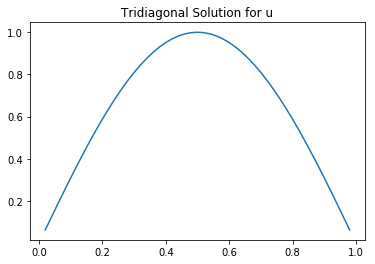

In [7]:
plt.title("Tridiagonal Solution for u")
plt.plot(X, V);

##### Part b)
The exact solution to the boundary value problem $(1)$ is $u(x) = \sin(\pi x)$. Check this.

If this is the exact solution, then 
$$Au = F$$
And furthermore,
$$v = u$$

Since we are using an approximation to the solution, the precision is based on the amount of nodes we use, so we instead check to see if each is close. Since the error is $O(h^{2})$ with $50$ nodes we should get an accuracy of about $O(10^{-3})$ so we check to see if the errors are within this range. This is done below:

In [9]:
closeness = 1e-3
u = lambda x: np.sin(np.pi * x)
U = np.vectorize(u)(X).reshape((N-1,1))

print("Error range = ", closeness)
print("Au = F", np.all(np.isclose(np.matmul(A, U), F, rtol=closeness)))
print("u = v", np.all(np.isclose(U, V, rtol=closeness)))

Error range =  0.001
Au = F True
u = v True


Now we plot the two solutions on the same plane to see how to compare:

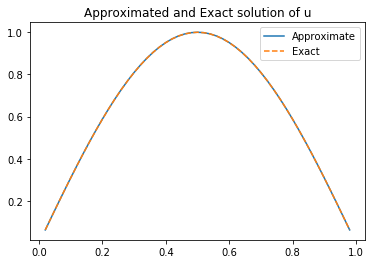

In [10]:
plt.title("Approximated and Exact solution of u")
plt.plot(X, V, label = "Approximate");
plt.plot(X, U, label = "Exact", linestyle="--")
plt.legend();

So they are very close!

Now a graph of the error:

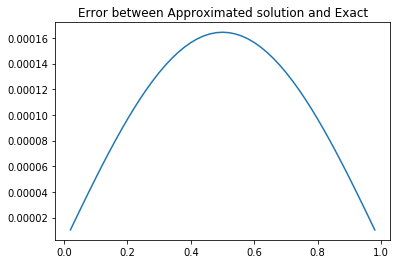

In [11]:
plt.title("Error between Approximated solution and Exact")
plt.plot(X, V-U);

##### Part c)
Compute the error of your approximation in the $2$-norm for $N =50$. Solve again $(2)$ for $N=100$, by how much would you expect the error to decrease? Verify your answer by comparing the error $N=50$ and $N=100$.

Calculating error in the $2$-norm for $N = 50$

In [12]:
err_50 = L_p_Norm(V,U, p = 2)
print("Error at N=50: ", err_50)

Error at N=50:  0.000822494085769116


Solving again for $N = 100$

In [13]:
N = 100
F_100, A_100, V_100, X_100 = boundaryProblem(N, f, c)
U_100 = np.vectorize(u)(X_100).reshape((N-1,1))

We would expect the error to decrease by a factor of $h^{2} \times \left(\frac{2}{h}\right)^2 = 4$. We now test it below:

In [14]:
err_100 = L_p_Norm(V_100,U_100, p = 2)
print("Error at N=100: ", err_100)

Error at N=100:  0.000290788399515632


In [15]:
err_ratio = err_50/err_100
print("The error ratio is: ", err_ratio)

The error ratio is:  2.828496897191048


Which is pretty close to the estimated decrease in the error.

##### Part d)
In real applications we do not know the exact solution. Describe a process to check the convergence and rate of convergence of your approximation if you don't know the exact solution.

##### Solution
A process to check would be to increase $h$ and check the ratio of the errors, as done above. An easy way is to halve $h$  and that gives a predictable error. Hence, after computing v for $h$, $h/2$ and $h/4$ we can evaluate the ratios and get an estimate for the rate of convergence. If it matches the theoretical rate of convergence, then we will be getting close to the actual value.

___

### Problem 3
Consider the linear system:

\begin{align*}
 x_{1} - 2x_{2} + x_{3} = -1\\
 2x_{1} + x_{2} - 3x_{3} = 3\\
x_{1} - x_{2} + x_{3} = 0
\end{align*}

###### Part a)
Do the first two iterations of Jacobi.

###### Solution
Rewriting the diagonal in their iterative solution form, we have:

\begin{align*}
& x_{1}^{(k+1)} = 2x_{2}^{(k)} -x_{3}^{(k)} - 1\\
& x_{2}^{(k+1)} = -2x_{1}^{(k)} + 3x_{3}^{(k)} + 3\\
& x_{3}^{(k+1)} = -x_{1}^{(k)} + x_{2}^{(k)}
\end{align*}

Now iterating and starting with 
$$
x^{(0)} = \begin{bmatrix}
0 \\ 0\\ 0
\end{bmatrix}
$$

First iteration,
\begin{align*}
& x_{1}^{(0+1)} = 2(0) -(0) - 1 = -1\\
& x_{2}^{(0+1)} = -2(0) + 3(0) + 3 = 3\\
& x_{3}^{(0+1)} = 0 + 0 = 0
\end{align*}
So then  
$$
x^{(1)} = \begin{bmatrix}
-1\\ 3\\ 0
\end{bmatrix}
$$

And the second iteration:
\begin{align*}
& x_{1}^{(1+1)} = 2(3) -(0) - 1 = 5\\
& x_{2}^{(1+1)} = -2(-1) + 3(0) + 3 = 5\\
& x_{3}^{(1+1)} = -(-1) + 3 = 0 = 4
\end{align*}
So then  
$$
x^{(2)} = \begin{bmatrix}
5\\ 5\\ 4
\end{bmatrix}
$$

##### Part b) 
Do the first two iterations of Gauss-Seidel.

###### Solution
To do Gauss-Seidel, we merely update the Jacobi iteration with the already computed components of $x^{(k+1)}$

\begin{align*}
& x_{1}^{(k+1)} = 2x_{2}^{(k)} -x_{3}^{(k)} - 1\\
& x_{2}^{(k+1)} = -2x_{1}^{(k+1)} + 3x_{3}^{(k)} + 3\\
& x_{3}^{(k+1)} = -x_{1}^{(k+1)} + x_{2}^{(k+1)}
\end{align*}

Now iterating and starting with 
$$
x^{(0)} = \begin{bmatrix}
0 \\ 0\\ 0
\end{bmatrix}
$$

First iteration,
\begin{align*}
& x_{1}^{(0+1)} = 2(0) -(0) - 1 = -1\\
& x_{2}^{(0+1)} = -2(-1) + 3(0) + 3 = 5\\
& x_{3}^{(0+1)} = -(-1) + (5) = 6
\end{align*}
So then  
$$
x^{(1)} = \begin{bmatrix}
-1\\ 5\\ 6
\end{bmatrix}
$$

And the second iteration:
\begin{align*}
& x_{1}^{(1+1)} = 2(5) -(6) - 1 = 3\\
& x_{2}^{(1+1)} = -2(3) + 3(6) + 3 = 15\\
& x_{3}^{(1+1)} = -(3) + (15) = 0 = 12
\end{align*}
So then  
$$
x^{(2)} = \begin{bmatrix}
3\\ 15\\ 12
\end{bmatrix}
$$



##### Part c)
Which of the two approximations is closer to the exact solution $(1,1,0)$?

##### Solution

Using the $\ell_{2}$ norm we check the error of both of the second iterations to see which is closer.

In [30]:
jacobi_2 = np.array([5,5,4])
gs_2 = np.array([3,15,12])
exact_sol = np.array([1,1,0])

jacobi_err = L_p_Norm(jacobi_2, exact_sol, 2)
gs_err = L_p_Norm(gs_2, exact_sol, 2)

print("Jacobian Iteration Error: {}".format(jacobi_err))
print("Gauss-Seidel Iteration Error: {}".format(gs_err))

Jacobian Iteration Error: 6.928203230275509
Gauss-Seidel Iteration Error: 18.547236990991408


The Jacobian Iteration is actually has closer than the Gauss-Seidel Method on two iterations. In fact, both methods diverge in this case, and when they both diverge, Gauss-Seidel always diverges faster than Jacobi iteration. So it makes sense that the Jacobi Iteration is closer.

____

### Problem 4
Consider the system

\begin{align*}
 2x_{1}-x_{2}+x_{3} = -1\\
 2x_{1}+2x_{2} + 2x_{3} = 4\\
 -x_{1}-x_{2} + 2x_{3} = -5
\end{align*}

By finding the spectral radius of the Jacobi and Gauss-Seidel iteration matrices prove that the Jacobi method diverges while Gauss-Seidel's method converges for this system.

##### Solution
For this system of equations, we have:

$$
A = \begin{bmatrix}
2 & -1 & 1\\
2 & 2 & 2\\
-1 & -1 & 2
\end{bmatrix}
$$

So then we must find the iteration matrix, $T$ of both the Jacobi and Gauss-Seidel Iteration.
We have that:
$$T = M^{-1}N = I - M^{-1}A$$

So for Jacobi iteration we have the following for $M$:

$$
M = \text{diag}(A) =  \begin{bmatrix}
2 & 0 & 0\\
0 & 2 & 0\\
0 & 0 & 2
\end{bmatrix} \implies
M^{-1} =  \begin{bmatrix}
\frac{1}{2} & 0 & 0\\
0 & \frac{1}{2} & 0\\
0 & 0 & \frac{1}{2}
\end{bmatrix}
$$

Then for T:
$$
T = I - M^{-1}A = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix} -\begin{bmatrix}
\frac{1}{2} & 0 & 0\\
0 & \frac{1}{2} & 0\\
0 & 0 & \frac{1}{2}
\end{bmatrix} \begin{bmatrix}
2 & -1 & 1\\
2 & 2 & 2\\
-1 & -1 & 2
\end{bmatrix} = \begin{bmatrix}0&\frac{1}{2}&-\frac{1}{2}\\ -1&0&-1\\ \frac{1}{2}&\frac{1}{2}&0\end{bmatrix}
$$

So then we have $\rho(T) = \max_{1\leq i \leq 3} \lvert{\lambda_{i}}\rvert$ for $\lambda_{i}$ being the i-th eigenvalue of $T$.

$$\rho(T) = \left\lvert i\frac{\sqrt{5}}{2}\right\rvert = \frac{\sqrt{5}}{2}$$
Which gives $\rho(T) = \frac{\sqrt{5}}{2} > 1$, so the Jacobi Iteration Method Diverges. 



Now repeating the process for the Gauss-Seidel Iteration:
This time, we have $M$ being the lower triangular section of $A$:

$$
M =\begin{bmatrix}
2 & 0 & 0\\
2 & 2 & 0\\
-1 & -1 & 2
\end{bmatrix} \implies M^{-1} = \begin{bmatrix}\frac{1}{2}&0&0\\ -\frac{1}{2}&\frac{1}{2}&0\\ 0&\frac{1}{4}&\frac{1}{2}\end{bmatrix}
$$ 

Then solving for $T$:
$$
T = I - M^{-1}A = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1
\end{bmatrix} - \begin{bmatrix}\frac{1}{2}&0&0\\ -\frac{1}{2}&\frac{1}{2}&0\\ 0&\frac{1}{4}&\frac{1}{2}\end{bmatrix}\begin{bmatrix}
2 & -1 & 1\\
2 & 2 & 2\\
-1 & -1 & 2
\end{bmatrix} = \begin{bmatrix}0&\frac{1}{2}&-\frac{1}{2}\\ 0&-\frac{1}{2}&-\frac{1}{2}\\ 0&0&-\frac{1}{2}\end{bmatrix}
$$

Then for $\rho(T)$:
$$\rho(T) = \left\lvert-\frac{1}{2}\right\rvert \frac{1}{2}$$

And clearly we have:
$$\rho(T) = \left\lvert-\frac{1}{2}\right\rvert \frac{1}{2} < 1$$

So the Gauss-Seidel Iteration method converges.